# 01. Data Processing

In [ ]:
"""
# Colab setup (optional)
!git clone https://github.com/c2g-dev/city2graph-case-study.git

import os
REPO_DIR = "/content/city2graph-case-study"
os.chdir(REPO_DIR)

# delete data directory
!rm -rf /content/city2graph-case-study/data

# download data zip from Zenodo and unzip into data/
!wget -O /content/city2graph-case-study/data.zip https://zenodo.org/records/18396286/files/data.zip?download=1
!unzip -o /content/city2graph-case-study/data.zip -d /content/city2graph-case-study/

%pip install city2graph
%pip install contextily
%pip install matplotlib_scalebar

os.chdir(REPO_DIR + "/notebooks")
"""

In [3]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np

import networkx as nx
import rustworkx as rx

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import contextily as ctx

import city2graph as c2g

# Constants
INPUT_PATH = "../data/raw/output_area/Output_Areas_2021_EW_BGC_V2.gpkg"
OUTPUT_DIR = "../data/processed/features"
TARGET_CRS = "EPSG:27700"
WGS84_CRS = "EPSG:4326"
TARGET_AUTHORITY = "Liverpool"

# Liverpool bounding box (WGS84)
BBOX = [-3.02, 53.31, -2.82, 53.48]
OVERTURE_DIR = "../data/raw/overture"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OVERTURE_DIR, exist_ok=True)

In [4]:
# Load Data
gdf = gpd.read_file(INPUT_PATH)

# Filter for Liverpool
liverpool_oa = gdf[gdf['LSOA21NM'].str.startswith(TARGET_AUTHORITY)].copy()

# Reproject
if liverpool_oa.crs != TARGET_CRS:
    liverpool_oa = liverpool_oa.to_crs(TARGET_CRS)

# Drop any that become empty
liverpool_oa = liverpool_oa[~liverpool_oa.geometry.is_empty & liverpool_oa.geometry.notna()].copy()

### 1.2 Process Overture Maps POI Data (Node Features)

#### Download POI Data

As of Dec. 28th 2025, the latest release for Overture Maps API is "2025-12-17.0". However, under the current data retention policy, the data is only available for 60 days. While the policy was changed on September 24th, 2025, its direction could be subject to change ([discussion](https://github.com/orgs/OvertureMaps/discussions/422)).

If the parameter `release="2025-12-17.0"` does not work in `c2g.load_overture_data`, please try to use the latest release by not specifying the `release` parameter. To reproduce the result of this case study, please download the data from Zenodo.

In [5]:
# Download 'place' type (POIs)
data = c2g.load_overture_data(
    area=BBOX,
    types=['place'],
    output_dir=OVERTURE_DIR,
    save_to_file=True,
    return_data=True,
    release='2025-12-17.0',
)

pois = data['place']

# Reproject to EPSG:27700
pois = pois.to_crs(crs=TARGET_CRS)

# Clip to Liverpool
pois = gpd.clip(pois, liverpool_oa)

# Save POIs as GeoPackage
pois.to_file(
    os.path.join(OVERTURE_DIR, "pois.gpkg"),
    driver="GPKG"
    )

#### Categorise POIs into Functional Classes

In [6]:
CATEGORY_MAPPING = {
    # RETAIL: GENERAL GOODS
    'retail': [
        # General & Department
        'antique_store', 'business_office_supplies_and_stationery', 'charity_shop',
        'department_store', 'discount_store', 'duty_free_shop', 'flea_market',
        'gift_shop', 'kiosk', 'outlet_store', 'packing_supply', 'party_supply',
        'pawn_shop', 'pop_up_shop', 'rental_kiosks', 'retail', 'second_hand_store',
        'shopping', 'shopping_center', 'shopping_mall', 'souvenir_shop', 'superstore',
        'thrift_store', 'used_vintage_and_consignment', 'warehouse_store',

        # Fashion & Clothing
        'baby_gear_and_furniture', 'baby_store', 'boutique', 'bridal_shop', 'bridal_store',
        'childrens_clothing_store', 'clothing_store', 'costume_store', 'custom_t_shirt_store',
        'dance_wear', 'fashion', 'fashion_accessories_store', 'furrier', 'hat_shop',
        'jewelry_store', 'leather_goods_store', 'linen', 'luggage_store', 'maternity_wear',
        'mens_clothing_store', 'plus_size_fashion', 'shoe_store', 'sunglasses_store',
        'swimwear_store', 'traditional_clothing', 'vintage_clothing_store', 'watch_store',
        'wig_store', 'womens_clothing_store',

        # Home, Garden & Hardware
        'appliance_store', 'bedding_and_bath_stores', 'building_supply_store', 'carpet_store',
        'electrical_supply_store', 'fireplace_store', 'flooring', 'flowers_and_gifts_shop',
        'flower_shop', 'florist', 'framing_store', 'furniture_store', 'garden_center',
        'glass_and_mirror_shop', 'hardware_store', 'home_decor', 'home_goods_store',
        'home_improvement_store', 'kitchen_supplies', 'lighting_store', 'mattress_store',
        'nursery_and_gardening', 'paint_store', 'shades_and_blinds', 'wallpaper_store',
        'window_treatment_store',

        # Electronics & Photo
        'camera_store', 'computer_store', 'electronics', 'electronics_store',
        'mobile_phone_store', 'music_and_dvd_store', 'printing_equipment_and_supply',
        'telecommunications', 'video_game_store',

        # Hobbies, Music & Art
        'art_supplies', 'arts_and_crafts', 'bicycle_shop', 'bookshop', 'bookstore',
        'comic_book_store', 'dive_shop', 'fabric_store', 'golf_equipment', 'guitar_store',
        'gun_shop', 'hobby_shop', 'hunting_and_fishing_supplies', 'music_store',
        'musical_instrument_store', 'newspaper_and_magazines_store', 'office_supplies',
        'outdoor_supply_store', 'record_shop', 'sewing_supply', 'skate_shop',
        'ski_and_snowboard_shop', 'sporting_goods', 'sporting_goods_store',
        'stationery_store', 'surf_shop', 'toy_store', 'trophy_shop', 'vinyl_record_store',

        # Specialty, Beauty Products & Adult
        'adult_store', 'beauty_product_supplier', 'candle_store', 'cosmetic_and_beauty_supplies',
        'cosmetics_and_beauty_supply', 'e_cigarette_store', 'firework_retailer',
        'hair_supply_stores', 'hearing_aids', 'lottery_ticket', 'perfume_store',
        'pet_food', 'pet_store', 'pet_supplies', 'reptile_shop', 'tobacco_shop', 'vape_store',

        # Groceries & Markets
        'convenience_store', 'farmers_market', 'frozen_foods', 'fruit_and_vegetable_store',
        'grocery_store', 'greengrocer', 'health_food_store', 'health_market',
        'international_grocery_store', 'korean_grocery_store', 'market',
        'organic_grocery_store', 'public_market', 'specialty_grocery_store', 'supermarket',

        # Specialty Food
        'butcher', 'butcher_shop', 'cheese_shop', 'dairy_stores', 'fishmonger',
        'honey_farm_shop', 'meat_shop', 'specialty_foods',

        # Alcohol (Retail)
        'beer_store', 'beverage_store', 'liquor_store', 'wine_shop'
    ],

    # DINING & DRINKING SERVICE
    'food_beverage': [
        # Restaurants (Cuisine Specific)
        'afghan_restaurant', 'african_restaurant', 'american_restaurant', 'argentine_restaurant',
        'asian_restaurant', 'australian_restaurant', 'belgian_restaurant', 'brazilian_restaurant',
        'british_restaurant', 'cajun_creole_restaurant', 'canadian_restaurant', 'caribbean_restaurant',
        'chinese_restaurant', 'cuban_restaurant', 'ethiopian_restaurant', 'filipino_restaurant',
        'french_restaurant', 'german_restaurant', 'greek_restaurant', 'himalayan_nepalese_restaurant',
        'indian_restaurant', 'irish_restaurant', 'italian_restaurant', 'jamaican_restaurant',
        'japanese_restaurant', 'korean_restaurant', 'kurdish_restaurant', 'lebanese_restaurant',
        'malaysian_restaurant', 'mediterranean_restaurant', 'mexican_restaurant',
        'middle_eastern_restaurant', 'moroccan_restaurant', 'pakistani_restaurant',
        'pan_asian_restaurant', 'persian_iranian_restaurant', 'peruvian_restaurant',
        'polish_restaurant', 'russian_restaurant', 'southern_restaurant', 'spanish_restaurant',
        'sushi_restaurant', 'syrian_restaurant', 'taiwanese_restaurant', 'thai_restaurant',
        'turkish_restaurant', 'venezuelan_restaurant', 'vietnamese_restaurant',

        # Restaurants (Type Specific)
        'bar_and_grill_restaurant', 'barbecue_restaurant', 'bbq_restaurant', 'bistro',
        'breakfast_and_brunch_restaurant', 'breakfast_brunch_restaurant', 'buffet',
        'buffet_restaurant', 'burger_restaurant', 'cafeteria', 'chicken_restaurant',
        'creperie', 'deli', 'dim_sum_restaurant', 'diner', 'fast_food_restaurant',
        'fish_and_chips_restaurant', 'fondue_restaurant', 'food_court', 'food_stand',
        'food_truck', 'gastropub', 'halal_restaurant', 'hot_dog_restaurant', 'kosher_restaurant',
        'noodle_restaurant', 'noodles_restaurant', 'pancake_house', 'pho_restaurant',
        'pizza_restaurant', 'poutinerie_restaurant', 'ramen_restaurant', 'restaurant',
        'sandwich_shop', 'seafood_restaurant', 'steakhouse', 'tapas_bar', 'tapas_restaurant',
        'vegan_restaurant', 'vegetarian_restaurant', 'wings_restaurant',

        # Cafes, Bakeries & Sweets
        'bagel_shop', 'bakery', 'bubble_tea', 'bubble_tea_shop', 'cafe', 'candy_store',
        'chocolate_shop', 'coffee_shop', 'cupcake_shop', 'desserts', 'donut_shop',
        'frozen_yogurt_shop', 'ice_cream_shop', 'internet_cafe', 'juice_bar', 'milk_bar',
        'patisserie_cake_shop', 'smoothie_juice_bar', 'tea_room',

        # Bars & Drinking
        'bar', 'beach_bar', 'beer_bar', 'brewery', 'champagne_bar', 'cocktail_bar',
        'dive_bar', 'hotel_bar', 'lounge', 'pub', 'sake_bar', 'sports_bar',
        'whiskey_bar', 'wine_bar',

        # Catering
        'bartender', 'caterer', 'catering', 'food_delivery_service', 'meal_prep', 'personal_chef'
    ],

    # BUSINESS & FINANCIAL
    'corporate_service': [
        # Financial
        'accountant', 'atms', 'audit_firm', 'auto_insurance', 'auto_loan_provider',
        'bank', 'bank_credit_union', 'banks', 'bookkeeper', 'collection_agencies',
        'currency_exchange', 'financial_advising', 'financial_service',
        'health_insurance_office', 'insurance_agency', 'investment_firm', 'life_insurance',
        'money_transfer_services', 'mortgage_broker', 'stock_broker', 'tax_services',

        # Corporate & Professional Services
        'advertising_agency', 'business', 'business_consulting',
        'business_management_services', 'business_to_business', 'call_center',
        'career_counseling', 'corporate_office', 'coworking_space', 'e_commerce_service',
        'employment_agencies', 'executive_search_consultants', 'graphic_designer',
        'hr_consulting', 'information_technology_company', 'internet_marketing_service',
        'management_consultant', 'marketing_agency', 'marketing_consultant', 'media_agency',
        'media_news_website', 'office_service', 'professional_services', 'public_relations',
        'recruitment_agency', 'software_development', 'talent_agency', 'telemarketing',
        'topic_publisher', 'translation_services', 'virtual_office', 'web_designer',

        # Legal
        'bail_bonds', 'divorce_and_family_law', 'employment_law', 'lawyer',
        'legal_firm', 'legal_services', 'notary', 'notary_public',

        # Real Estate (Office)
        'apartment_agent', 'commercial_real_estate', 'escrow_service', 'housing_cooperative',
        'property_management', 'real_estate', 'real_estate_agent', 'real_estate_appraiser',
        'real_estate_service', 'title_company'
    ],

    # INDUSTRIAL & TRADES
    'industrial_service': [
        # Construction & Trades
        'architect', 'architectural_designer', 'bathroom_remodeling', 'building_contractor',
        'carpenter', 'chemical_plant', 'chimney_sweep', 'construction_services', 'contractor',
        'electrician', 'energy_equipment_and_solution', 'engineering_services',
        'fence_and_gate_sales_service', 'fire_and_water_damage_restoration',
        'fire_protection_service', 'fireplace_service', 'flooring_contractor',
        'flooring_contractors', 'forestry_service', 'gardener', 'general_contractor',
        'glass_and_mirror_sales_service', 'gutter_service', 'handyman', 'home_developer',
        'home_security', 'home_service', 'hvac_services', 'interior_design',
        'junk_removal_and_hauling', 'key_and_locksmith', 'kitchen_remodeling',
        'land_surveying', 'landscaping', 'locksmith', 'masonry', 'painter', 'painting',
        'pest_control', 'pest_control_service', 'plastic_fabrication_company', 'plumber',
        'plumbing', 'roofer', 'roofing', 'security_services', 'tree_services',
        'window_installation', 'window_washing',

        # Wholesale & Manufacturing
        'appliance_manufacturer', 'business_manufacturing_and_supply', 'clothing_company',
        'distributor', 'electrical_wholesaler', 'food_beverage_service_distribution',
        'furniture_manufacturers', 'importer_and_exporter', 'industrial_equipment',
        'industrial_equipment_supplier', 'machine_and_tool_rentals', 'metal_supplier',
        'office_equipment', 'print_shop', 'printing_services', 'screen_printing', 'sign_shop',
        'wholesale_grocer', 'wholesaler', 'wine_wholesaler',
    ],

    # CONSUMER SERVICES
    'consumer_service': [
        # Cleaning & Laundry
        'carpet_cleaning', 'cleaning_services', 'dry_cleaning', 'gents_tailor',
        'home_cleaning', 'laundromat', 'laundry_service', 'laundry_services',
        'leather_repair', 'office_cleaning', 'sewing_and_alterations', 'shoe_repair', 'tailor',

        # Storage & Moving
        'luggage_storage', 'movers', 'moving_company', 'organization', 'self_storage',
        'storage', 'storage_facility',

        # Tech & Media
        'appliance_repair_service', 'broadcasting_media_production', 'event_photography',
        'it_service_and_computer_repair', 'movie_television_studio', 'music_production',
        'photo_booth', 'photo_booth_rental', 'photographer',
        'photography_store_and_services',

        # Pets
        'animal_shelter', 'animal_hospital', 'dog_groomer', 'dog_walker', 'kennel',
        'pet_clinic', 'pet_groomer', 'pet_services', 'veterinarian',

        # Travel Agents
        'passport_and_visa_services', 'tour_operator', 'travel', 'travel_agency',
        'travel_agents', 'travel_services',

        # Death Care
        'cemetery', 'cemeteries', 'crematory', 'funeral_home',
        'funeral_services_and_cemeteries',

        # BEAUTY & WELLNESS
        'barber', 'barber_shop', 'beauty_and_spa', 'beauty_salon', 'day_spa',
        'hair_loss_center', 'hair_removal', 'hair_salon', 'hair_stylist', 'kids_hair_salon',
        'laser_hair_removal', 'makeup_artist', 'massage', 'nail_salon', 'permanent_makeup',
        'sauna', 'skin_care', 'spas', 'tanning_salon', 'tattoo_and_piercing',
        'tattoo_removal', 'teeth_whitening', 'waxing',

        # Misc
        'life_coach'
    ],

    # HEALTHCARE
    'healthcare': [
        # Practitioners
        'allergist', 'anesthesiologist', 'cardiologist', 'chiropractor',
        'cosmetic_surgeon', 'dentist', 'dermatologist', 'doctor', 'endocrinologist',
        'endodontist', 'eyewear_and_optician', 'family_practice', 'gastroenterologist',
        'general_dentistry', 'general_practitioner', 'hematologist',
        'infectious_disease_specialist', 'nephrologist', 'neurologist', 'nutritionist',
        'obstetrician_and_gynecologist', 'occupational_therapist', 'oncologist',
        'ophthalmologist', 'optometrist', 'oral_surgeon', 'orthodontist',
        'orthopedic_surgeon', 'pain_management', 'pediatrician', 'physical_therapist',
        'physical_therapy', 'physiotherapist', 'plastic_surgeon', 'podiatrist',
        'psychiatrist', 'psychologist', 'pulmonologist', 'radiologist', 'rheumatologist',
        'sports_medicine', 'urologist',

        # Facilities
        'blood_and_plasma_donation_center', 'blood_bank', 'clinic', 'clinical_laboratories',
        'diagnostic_services', 'emergency_room', 'health_and_medical', 'hospital',
        'laboratory', 'medical_center', 'medical_research_and_development',
        'outpatient_clinic', 'public_health_clinic', 'rehabilitation_center', 'urgent_care',

        # Senior & Care
        'adult_day_care', 'assisted_living', 'assisted_living_facility', 'home_health_care',
        'hospice', 'nursing_home', 'retirement_home', 'skilled_nursing',

        # Mental Health
        'addiction_rehabilitation_center', 'alcohol_and_drug_treatment_centers',
        'counseling', 'counseling_and_mental_health', 'counselor',
        'mental_health_services', 'psychotherapy', 'therapist',

        # Alternative
        'acupuncture', 'alternative_medicine', 'herbalist', 'homeopath', 'massage_therapy',
        'naturopath', 'naturopathic_holistic', 'osteopath', 'reflexology', 'reiki',

        # Pharmacy & Supplies
        'drugstore', 'medical_supply', 'medical_supply_store', 'mobility_equipment_services',
        'orthotics', 'pharmacy', 'prosthetics', 'weight_loss_center'
    ],

    # EDUCATION
    'education': [
        # Schools
        'art_school', 'boarding_school', 'business_schools', 'college', 'college_university',
        'community_college', 'cooking_school', 'cosmetology_school', 'drama_school',
        'driving_school', 'educational_services', 'elementary_school', 'flight_school',
        'high_school', 'kindergarten', 'language_school', 'law_school', 'massage_school',
        'medical_sciences_schools', 'middle_school', 'montessori_school', 'music_school',
        'nursery', 'preschool', 'private_school', 'public_school', 'religious_school',
        'school', 'science_schools', 'special_education_school', 'technical_school',
        'trade_school', 'university', 'vocational_school', 'waldorf_school', 'academic_library'

        # Training & Support
        'adult_education', 'art_classes', 'barber_school', 'campus_building',
        'child_care_and_day_care', 'childcare', 'cpr_classes', 'dance_school',
        'day_care_preschool', 'education', 'first_aid_training', 'food_safety_training',
        'learning_center', 'music_lessons', 'private_tutor', 'study_hall', 'test_prep',
        'training_center', 'tutoring_center'
    ],

    # GOVERNMENT & COMMUNITY
    'public_service': [
        # Government
        'central_government_office', 'city_hall', 'consulate', 'courthouse', 'embassy',
        'fire_department', 'fire_station', 'government_building', 'government_services',
        'jail', 'jail_and_prison', 'law_enforcement', 'military_base', 'police_department',
        'police_station', 'post_office', 'prison', 'public_service_and_government',

        # Community
        'charity_organization', 'community_center',
        'community_services_non_profits', 'food_bank', 'food_banks', 'homeless_shelter',
        'library', 'public_bathroom', 'public_library', 'scout_hall', 'senior_center',
        'social_and_human_services', 'social_service_organizations', 'youth_organizations'
    ],

    # TRANSPORT & AUTO
    'transportation_facility': [
        # Terminals & Stops
        'airport', 'airport_lounge', 'airport_terminal', 'airstrip', 'bus_station',
        'bus_stop', 'commuter_rail_station', 'ferry_terminal', 'heliport', 'metro_station',
        'pier', 'port', 'public_transportation', 'subway_station', 'train_station',
        'tram_stop', 'transportation',

        # Rental & Fleet
        'ambulance_service', 'bike_rental', 'boat_rental_and_training', 'bus_charter',
        'car_rental', 'car_rental_agency', 'limo_services', 'limousine_service',
        'private_car_service', 'rental_service', 'rental_services', 'rideshare',
        'scooter_rental', 'shuttle_service', 'taxi_service', 'taxi_stand', 'truck_rental',
        'van_rental', 'yacht_charter',

        # Logistics (Physical)
        'courier', 'courier_and_delivery_services', 'freight_and_cargo_service',
        'freight_forwarding_agency', 'motor_freight_trucking', 'package_locker',
        'shipping_center', 'trucking_company'
    ],

    'automotive_facility': [
        # Service
        'auto_body_shop', 'auto_detailing', 'auto_glass_services', 'auto_repair',
        'auto_upholstery', 'automotive', 'automotive_repair',
        'automotive_services_and_repair', 'brake_service_and_repair', 'car_wash',
        'emissions_inspection', 'mechanic', 'motorcycle_repair', 'oil_change_station',
        'tire_dealer_and_repair', 'tire_repair_shop', 'tire_shop', 'towing_service',
        'transmission_repair', 'vehicle_inspection',

        # Sales
        'auto_manufacturers_and_distributors', 'automotive_parts_and_accessories',
        'car_dealer', 'motorcycle_dealer', 'part_store', 'recreational_vehicle_dealer',
        'trailer_dealer', 'truck_dealer', 'used_car_dealer',

        # Infrastructure
        'charging_station', 'ev_charging_station', 'fuel_station', 'gas_station',
        'parking', 'parking_garage', 'parking_lot', 'petrol_station', 'valet_parking'
    ],

    # ACCOMMODATION
    'hotel_lodging': [
        'accommodation', 'bed_and_breakfast', 'cabin', 'campground', 'cottage',
        'guest_house', 'hostel', 'hotel', 'inn', 'lodging', 'motel', 'resort', 'rv_park',
        'vacation_rental'
    ],

    # RECREATION & NATURE
    'sports_fitness': [
        'active_life', 'arena', 'athletic_field', 'baseball_field', 'basketball_court',
        'bowling_alley', 'boxing_gym', 'climbing_gym', 'cricket_ground', 'driving_range',
        'fitness_center', 'fitness_trainer', 'football_club', 'football_stadium',
        'golf_club', 'golf_course', 'gym', 'ice_skating', 'leisure_center',
        'martial_arts_club', 'martial_arts_school', 'miniature_golf_course', 'pilates_studio',
        'public_swimming_pool', 'racetrack', 'recreation_center', 'rock_climbing',
        'roller_skating', 'rugby_club', 'skate_park', 'skating_rink', 'soccer_club',
        'soccer_stadium', 'sports_and_recreation_venue', 'sports_club_and_league',
        'sports_field', 'stadium', 'stadium_arena', 'swimming_instructor', 'swimming_pool',
        'tennis_court', 'yoga_studio'
    ],

    'park': [
        'beach', 'botanical_garden', 'city_park', 'dog_park', 'forest', 'garden',
        'hiking_trail', 'lake', 'national_park', 'nature_reserve', 'park', 'playground',
        'state_park', 'wildlife_sanctuary'
    ],

    # ARTS, ENTERTAINMENT & RELIGION
    'arts_culture': [
        'aquarium', 'art_gallery', 'art_museum', 'attractions_and_activities', 'castle',
        'childrens_museum', 'cultural_center', 'historic_site', 'historical_place',
        'history_museum', 'landmark_and_historical_building', 'memorial', 'monument',
        'museum', 'planetarium', 'science_center', 'science_museum', 'sculpture_statue',
        'tourist_information', 'tours', 'visitor_center', 'zoo'
    ],

    'entertainment': [
        # Venues & Events
        'amphitheater', 'arts_and_entertainment', 'banquet_hall', 'cinema', 'club',
        'concert_hall', 'corporate_entertainment_services', 'drive_in_theater',
        'event_planning', 'event_technology_service', 'event_venue', 'fraternal_organization',
        'movie_theater', 'music_venue', 'opera_house', 'party_and_event_planning',
        'party_equipment_rental', 'performing_arts_venue', 'social_club', 'theater',
        'theatre', 'topic_concert_venue', 'venue_and_event_space', 'wedding_venue',

        # Nightlife
        'adult_entertainment', 'comedy_club', 'dance_club', 'gay_bar', 'jazz_and_blues',
        'karaoke', 'nightclub', 'nightlife',

        # Gaming & Fun
        'amusement_park', 'arcade', 'betting_center', 'billiards_or_pool_hall', 'bingo_hall',
        'bookmakers', 'carnival', 'casino', 'circus', 'escape_room', 'game_room',
        'go_kart_track', 'kids_recreation_and_party', 'laser_tag', 'paintball',
        'theme_park', 'trampoline_park', 'video_arcade', 'water_park'
    ],

    'religion': [
        'anglican_church', 'buddhist_temple', 'cathedral', 'catholic_church', 'chapel',
        'church', 'church_cathedral', 'convent', 'hindu_temple',
        'jehovahs_witness_kingdom_hall', 'kingdom_hall', 'monastery', 'mosque',
        'religious_organization', 'shrine', 'sikh_temple', 'synagogue', 'temple'
    ]
}

# HELPER: REVERSE LOOKUP
def get_reverse_mapping(mapping_dict):
    """
    Generates a dictionary where Keys = Specific Types (e.g. 'sushi')
    and Values = Category (e.g. 'food_service').
    Checks for duplicates.
    """
    reverse_map = {}
    duplicates = []

    for category, items in mapping_dict.items():
        for item in items:
            if item in reverse_map:
                duplicates.append(f"{item} (found in {reverse_map[item]} and {category})")
            reverse_map[item] = category

    if duplicates:
        print(f"Warning: Found duplicates in mapping: {duplicates}")

    return reverse_map

CATEGORY_TO_CLASS = get_reverse_mapping(CATEGORY_MAPPING)

In [7]:
# Add src to path
sys.path.append(os.path.abspath('../src'))

def classify_poi(cats):
    """Classify a POI based on its categories dict."""
    if pd.isna(cats) or not isinstance(cats, dict):
        return 'other'
    
    # Check primary category first
    primary = cats.get('primary', '')
    if primary in CATEGORY_TO_CLASS:
        return CATEGORY_TO_CLASS[primary]
    
    # Check alternate categories
    alt = cats.get('alternate', None)
    if alt is not None:
        if isinstance(alt, np.ndarray):
            alt = alt.tolist()
        elif isinstance(alt, list):
            pass
        else:
            # Fallback for unexpected types
            return 'other'
            
        for a in alt:
            if a in CATEGORY_TO_CLASS:
                return CATEGORY_TO_CLASS[a]
        
# Classify POIs
pois['functional_class'] = pois['categories'].apply(classify_poi)
print("POIs by functional class:")
print(pois['functional_class'].value_counts())

POIs by functional class:
functional_class
retail                     3656
food_beverage              3624
corporate_service          2766
consumer_service           2570
healthcare                 1501
industrial_service         1405
education                  1065
automotive_facility        1005
public_service              836
entertainment               824
sports_fitness              672
transportation_facility     612
hotel_lodging               521
arts_culture                446
religion                    440
park                        207
Name: count, dtype: int64


#### Spatial Join POIs to OAs

In [8]:
# Reproject POIs to match OAs
pois_proj = pois.to_crs(TARGET_CRS)

# Spatial join
pois_with_oa = gpd.sjoin(pois_proj, liverpool_oa[['OA21CD', 'geometry']], 
                           how='left', predicate='within')
pois_matched = pois_with_oa[~pois_with_oa['OA21CD'].isna()]

#### Aggregate and Normalise Features

In [9]:
# Aggregate POI counts per OA per functional class
oa_with_features = pois_matched.groupby(['OA21CD', 'functional_class']).size().unstack(fill_value=0)

# Ensure all OAs are represented
oa_with_features = oa_with_features.reindex(liverpool_oa['OA21CD']).fillna(0)

# Merge with OA geometry
oa_with_features = liverpool_oa[["OA21CD", "LSOA21CD", "LSOA21NM", "geometry"]].merge(oa_with_features, on='OA21CD')

# Set index
oa_with_features = oa_with_features.set_index("OA21CD")

In [10]:
oa_with_features.head()

LSOA21CD        LSOA21NM  \
OA21CD                                 
E00032987  E01034403  Liverpool 037H   
E00032988  E01006514  Liverpool 037A   
E00032989  E01033768  Liverpool 037F   
E00032990  E01033768  Liverpool 037F   
E00032991  E01033768  Liverpool 037F   

                                                    geometry  arts_culture  \
OA21CD                                                                       
E00032987  MULTIPOLYGON (((335187 389431.935, 335187.298 ...           0.0   
E00032988  MULTIPOLYGON (((335674.52 389521.35, 335512 38...           0.0   
E00032989  MULTIPOLYGON (((336030.837 389353.117, 336003....           1.0   
E00032990  MULTIPOLYGON (((336030.837 389353.117, 336158 ...           1.0   
E00032991  MULTIPOLYGON (((335804.882 389421.653, 335690....           0.0   

           automotive_facility  consumer_service  corporate_service  \
OA21CD                                                                
E00032987                  0.0               0.0                2.0   
E00032988                  1.0               1.0                0.0   
E00032989                  0.0               0.0                1.0   
E00032990                  0.0               0.0                0.0   
E00032991                  2.0               0.0                0.0   

           education  entertainment  food_beverage  healthcare  hotel_lodging  \
OA21CD                                                                          
E00032987        0.0            2.0            2.0         0.0            0.0   
E00032988        0.0            0.0            1.0         1.0            0.0   
E00032989        0.0            0.0            0.0         0.0            0.0   
E00032990        0.0            0.0            0.0         0.0            2.0   
E00032991        0.0            0.0            0.0         0.0            0.0   

           industrial_service  park  public_service  religion  retail  \
OA21CD                                                                  
E00032987                 0.0   0.0             3.0       1.0     2.0   
E00032988                 1.0   0.0             0.0       4.0     0.0   
E00032989                 0.0   0.0             0.0       0.0     2.0   
E00032990                 0.0   1.0             0.0       0.0     0.0   
E00032991                 0.0   0.0             0.0       0.0     0.0   

           sports_fitness  transportation_facility  
OA21CD                                              
E00032987             0.0                      0.0  
E00032988             1.0                      0.0  
E00032989             0.0                      0.0  
E00032990             0.0                      0.0  
E00032991             0.0                      0.0

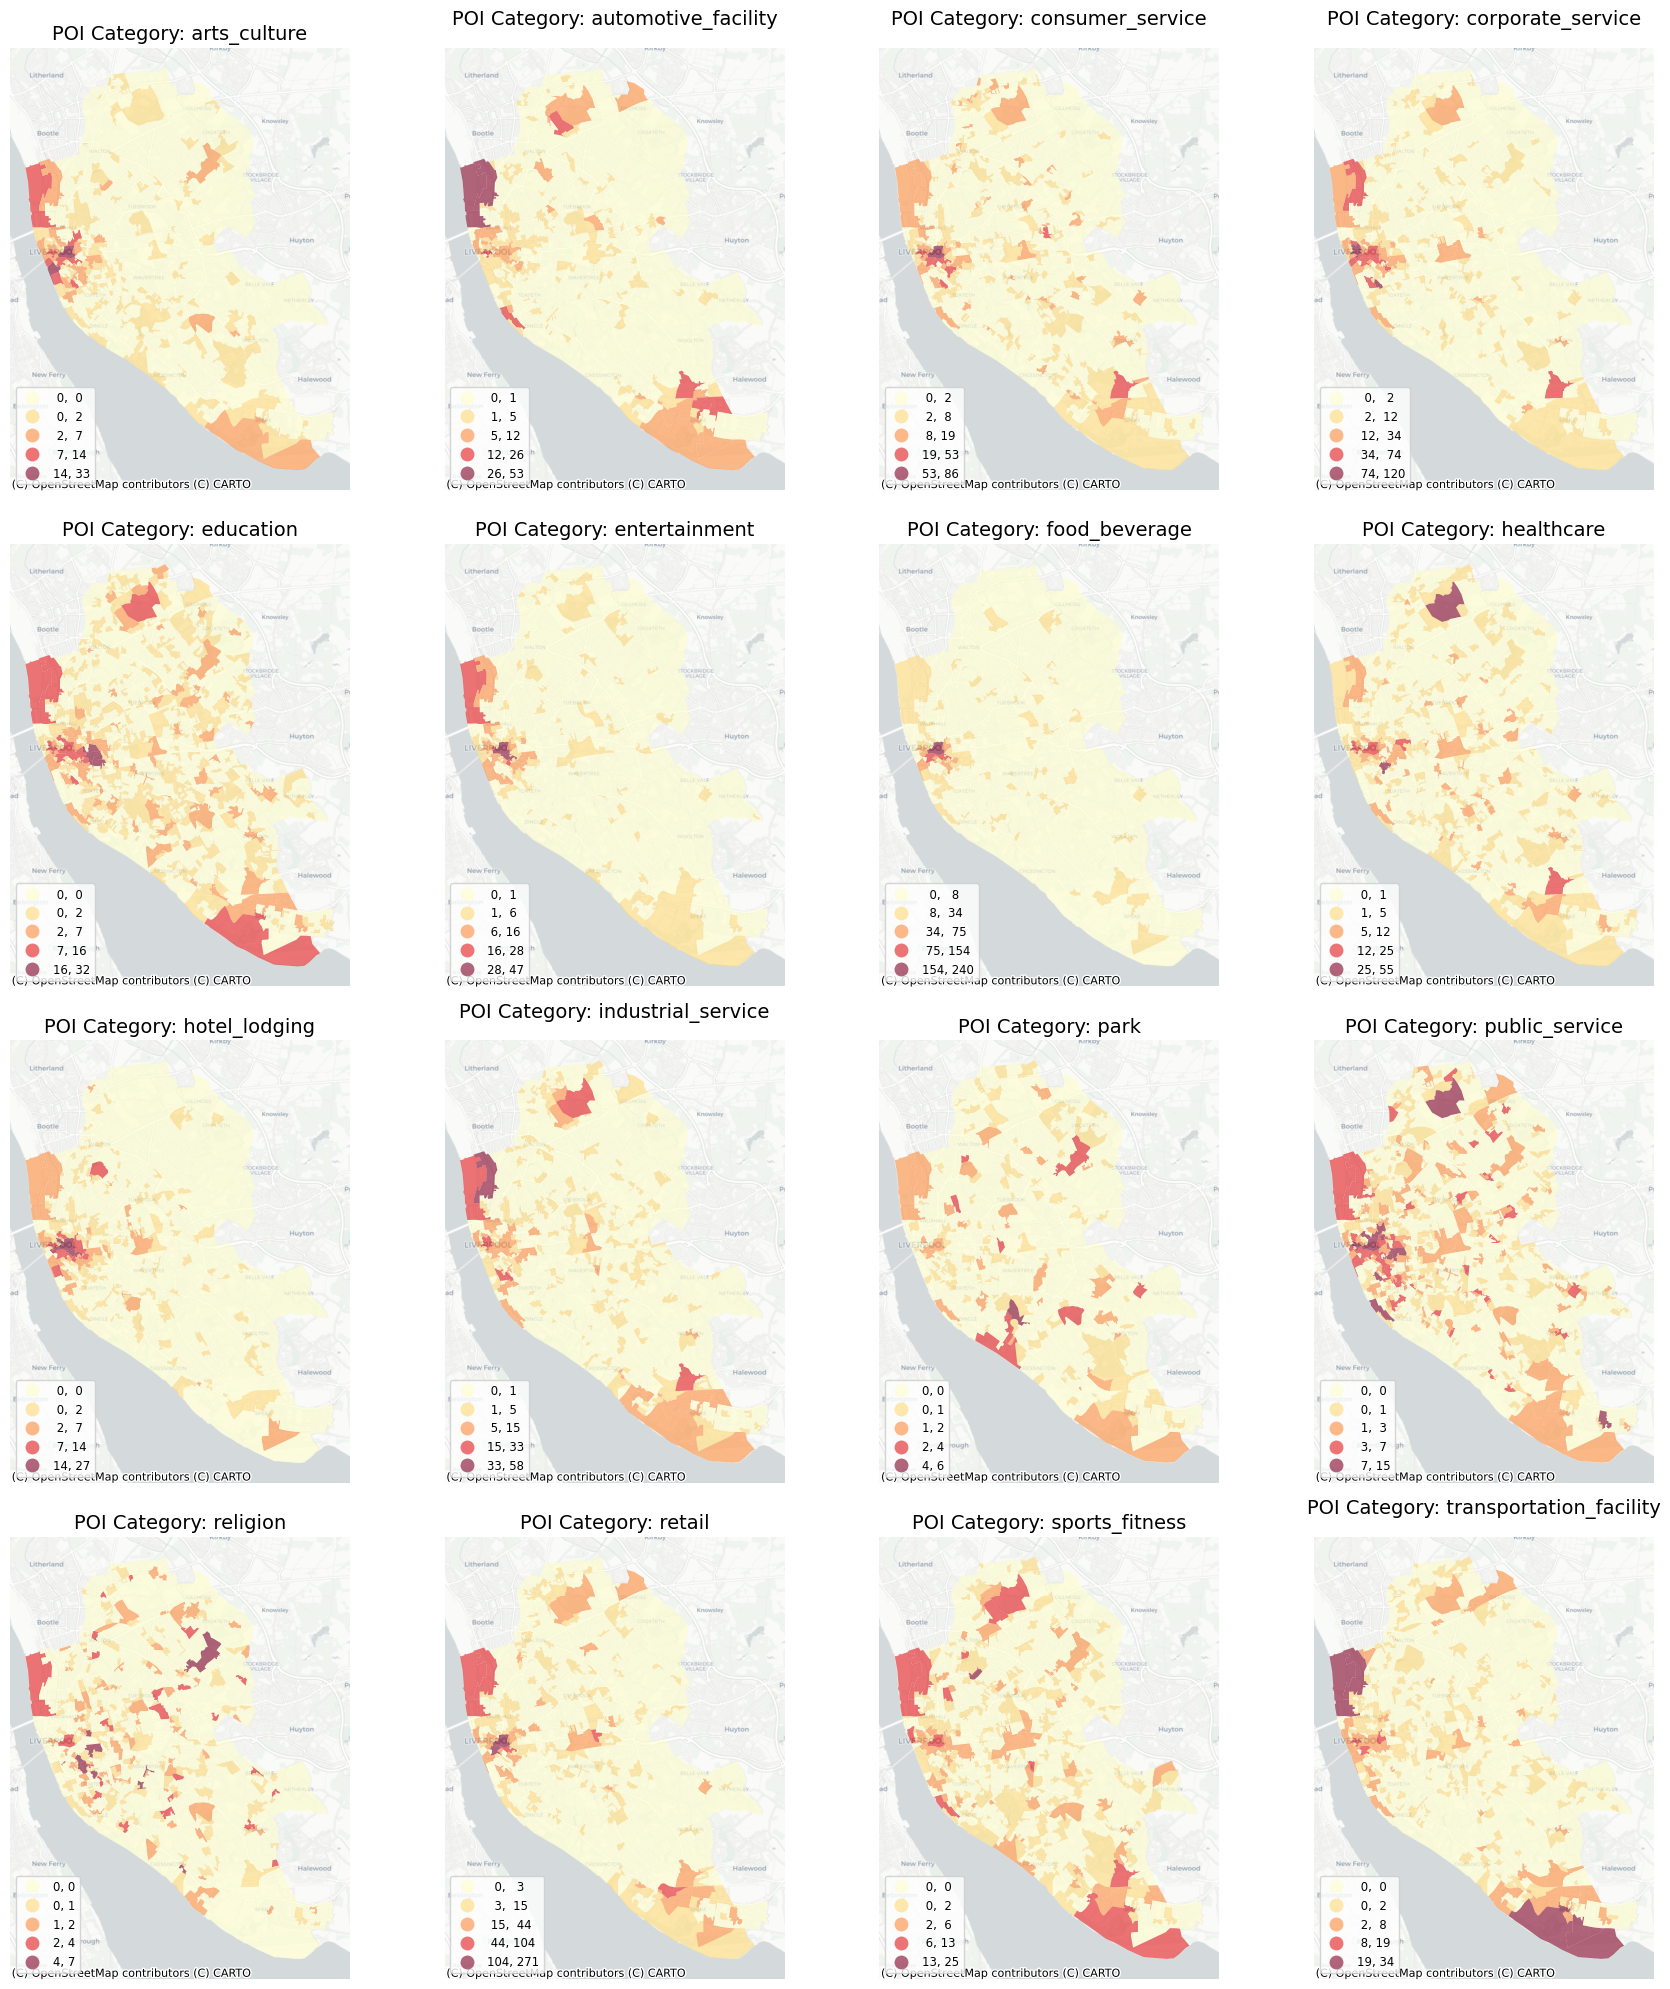

In [11]:
categories = [c for c in oa_with_features.columns if c not in ['geometry', 'LSOA21CD', 'LSOA21NM']]
n_cols = 4
n_rows = (len(categories) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categories):
    oa_with_features.to_crs("EPSG:3857").plot(
        column=col,
        ax=axes[i],
        scheme='NaturalBreaks',
        k=5,
        legend=True, 
        cmap='YlOrRd',
        alpha=0.6,
        linewidth=0,
        legend_kwds={'loc': 'lower left', 'fmt': "{:.0f}", 'fontsize': 'small'}
    )

    # Add the basemap to each axis
    ctx.add_basemap(axes[i], source=ctx.providers.CartoDB.Positron)
    
    axes[i].set_title(f'POI Category: {col}', fontsize=14)
    axes[i].set_axis_off()

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 1.3 Process Overture Maps Land Use Data (Node Features)

As of Dec. 28th 2025, the latest release for Overture Maps API is "2025-12-17.0". However, under the current data retention policy, the data is only available for 60 days. While the policy was changed on September 24th, 2025, its direction could be subject to change ([discussion](https://github.com/orgs/OvertureMaps/discussions/422)).

If the parameter `release="2025-12-17.0"` does not work in `c2g.load_overture_data`, please try to use the latest release by not specifying the `release` parameter. To reproduce the result of this case study, please download the data from Zenodo.

In [12]:
# Download 'place' type (POIs)
data = c2g.load_overture_data(
    area=BBOX,
    types=['land_use'],
    output_dir=OVERTURE_DIR,
    save_to_file=True,
    return_data=True,
    release='2025-12-17.0',
)

land_uses = data['land_use']

# Reproject to EPSG:27700
land_uses = land_uses.to_crs(crs=TARGET_CRS)

# Clip to Liverpool
land_uses = gpd.clip(land_uses, liverpool_oa)

# Save POIs as GeoPackage
land_uses.to_file(
    os.path.join(OVERTURE_DIR, "land_uses.gpkg"),
    driver="GPKG"
    )

In [13]:
# Load Land Use Data
land_use_path = "../data/raw/overture/land_uses.gpkg"
land_uses = gpd.read_file(land_use_path)

# Define Category Mapping (Class -> Functional Group)
LAND_USE_MAPPING = {
    'residential': ['residential', 'garages'],
    'commercial': ['commercial', 'retail', 'plaza'],
    'industrial': ['industrial', 'works', 'brownfield', 'construction'],
    'public_services': ['school', 'university', 'college', 'hospital', 'clinic', 'doctors', 'religious', 'military', 'base', 'cemetery', 'grave_yard'],
    'green_space': ['park', 'grass', 'garden', 'meadow', 'nature_reserve', 'village_green', 'green', 'greenfield', 'flowerbed', 'orchard', 'allotments', 'recreation_ground', 'playground', 'pitch', 'stadium', 'golf_course', 'fairway', 'tee', 'bunker', 'rough', 'water_hazard'],
    'transportation': ['railway', 'track', 'pedestrian'],
    'agricultural': ['farmland', 'farmyard'],
    'other': []
}

# HELPER: REVERSE LOOKUP
def get_reverse_mapping(mapping_dict):
    """
    Generates a dictionary where Keys = Specific Types (e.g. 'residential')
    and Values = Category (e.g. 'residential').
    """
    reverse_map = {}
    duplicates = []
    for category, items in mapping_dict.items():
        for item in items:
            if item in reverse_map:
                duplicates.append(f"{item} (found in {reverse_map[item]} and {category})")
            reverse_map[item] = category
    if duplicates:
        print(f"Warning: Found duplicates in mapping: {duplicates}")
    return reverse_map

LAND_USE_TO_CLASS = get_reverse_mapping(LAND_USE_MAPPING)

def map_land_use_class(cls):
    """Maps a detailed land use class to a broader functional class."""
    if pd.isna(cls):
        return 'other'
    return LAND_USE_TO_CLASS.get(cls, 'other')

# Apply the mapping
land_uses['land_use_class'] = land_uses['class'].apply(map_land_use_class)

# Inspect mapped classes
print(land_uses['land_use_class'].value_counts())


land_use_class
green_space        4184
residential         462
industrial          292
public_services     254
transportation      222
commercial          212
agricultural         39
Name: count, dtype: int64


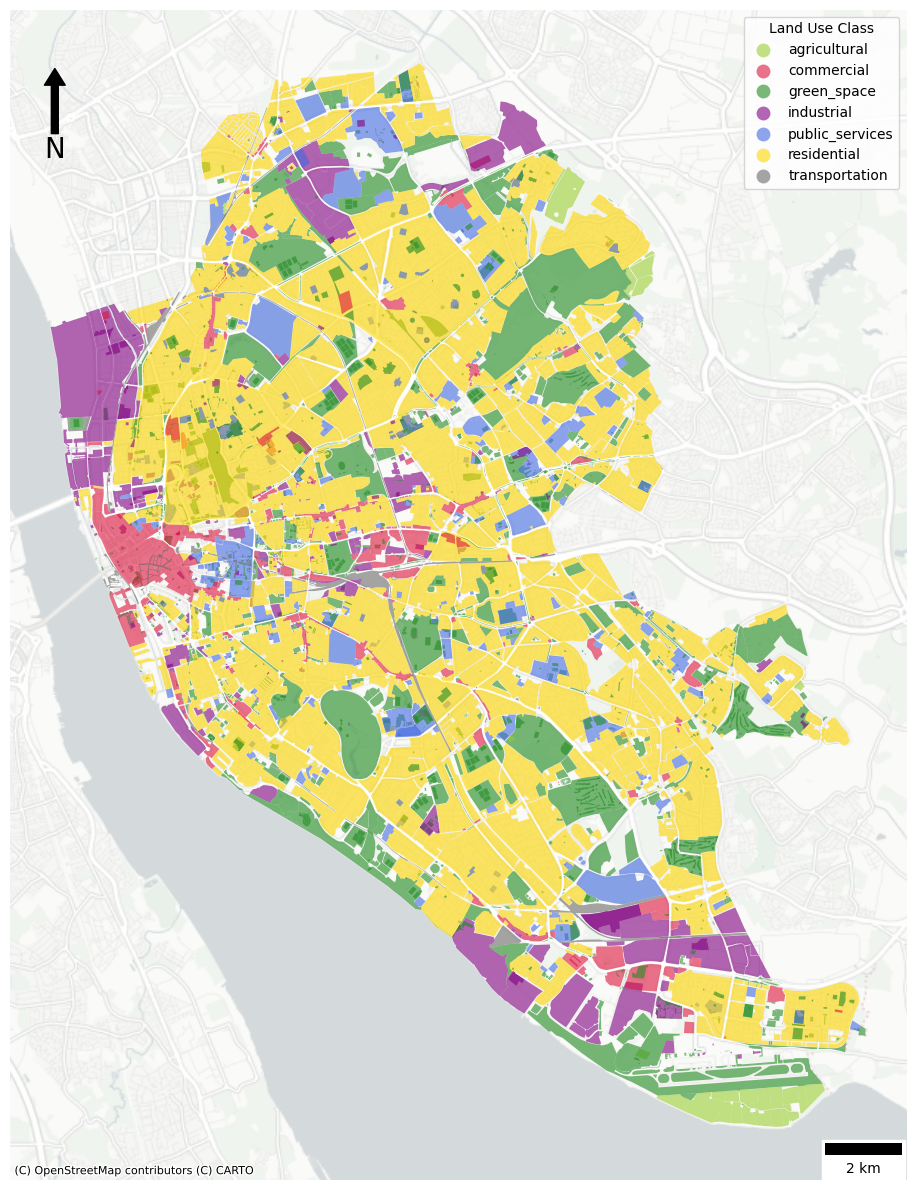

In [14]:
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Define a more distinct and accessible color palette
land_use_colors = {
    'green_space': '#228B22',      # Forest Green
    'residential': '#FFD700',      # Gold
    'industrial': '#800080',       # Purple
    'public_services': '#4169E1',  # Royal Blue
    'transportation': '#696969',   # Dim Gray
    'commercial': '#DC143C',       # Crimson
    'agricultural': '#9ACD32'      # Yellow Green
}

# Ensure colors are mapped to the sorted unique categories present in the data
categories = sorted(land_uses['land_use_class'].unique())
cmap = ListedColormap([land_use_colors.get(cat, '#000000') for cat in categories])

fig, ax = plt.subplots(figsize=(12, 12))
# Convert to Web Mercator for contextily compatibility
land_uses_3857 = land_uses.to_crs(epsg=3857)
land_uses_3857.plot(
    column='land_use_class',
    ax=ax,
    legend=True,
    categorical=True,
    cmap=cmap,
    alpha=0.6,
    legend_kwds={'loc': 'upper right', 'title': 'Land Use Class', 'frameon': True}
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)

# Add scale bar (EPSG:3857 is in meters)
ax.add_artist(ScaleBar(1, location='lower right'))

# Add north mark
x, y, arrow_length = 0.05, 0.95, 0.07
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords='axes fraction')

ax.set_axis_off()
plt.tight_layout()
plt.show()


In [15]:
# Filter land_uses to only keep Polygons and MultiPolygons before overlay
land_uses = land_uses[land_uses.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Calculate Area Coverage per OA
# Intersect land use polygons with OAs to assign areas correctly
land_use_intersection = gpd.overlay(land_uses, liverpool_oa[['OA21CD', 'geometry']], how='intersection')
land_use_intersection['area'] = land_use_intersection.geometry.area

# Group by OA and Functional Class, then sum area
land_use_areas = land_use_intersection.groupby(['OA21CD', 'land_use_class'])['area'].sum().unstack(fill_value=0)

# Rename columns
land_use_areas.columns = [f"land_use_{c.lower().replace(' ', '_').replace('/', '_')}" for c in land_use_areas.columns]

In [16]:
# Merge with existing OA features
oa_with_features = oa_with_features.merge(land_use_areas, on='OA21CD', how='left').fillna(0)

display(oa_with_features.head())

LSOA21CD        LSOA21NM  \
OA21CD                                 
E00032987  E01034403  Liverpool 037H   
E00032988  E01006514  Liverpool 037A   
E00032989  E01033768  Liverpool 037F   
E00032990  E01033768  Liverpool 037F   
E00032991  E01033768  Liverpool 037F   

                                                    geometry  arts_culture  \
OA21CD                                                                       
E00032987  MULTIPOLYGON (((335187 389431.935, 335187.298 ...           0.0   
E00032988  MULTIPOLYGON (((335674.52 389521.35, 335512 38...           0.0   
E00032989  MULTIPOLYGON (((336030.837 389353.117, 336003....           1.0   
E00032990  MULTIPOLYGON (((336030.837 389353.117, 336158 ...           1.0   
E00032991  MULTIPOLYGON (((335804.882 389421.653, 335690....           0.0   

           automotive_facility  consumer_service  corporate_service  \
OA21CD                                                                
E00032987                  0.0               0.0                2.0   
E00032988                  1.0               1.0                0.0   
E00032989                  0.0               0.0                1.0   
E00032990                  0.0               0.0                0.0   
E00032991                  2.0               0.0                0.0   

           education  entertainment  food_beverage  ...  retail  \
OA21CD                                              ...           
E00032987        0.0            2.0            2.0  ...     2.0   
E00032988        0.0            0.0            1.0  ...     0.0   
E00032989        0.0            0.0            0.0  ...     2.0   
E00032990        0.0            0.0            0.0  ...     0.0   
E00032991        0.0            0.0            0.0  ...     0.0   

           sports_fitness  transportation_facility  land_use_agricultural  \
OA21CD                                                                      
E00032987             0.0                      0.0                    0.0   
E00032988             1.0                      0.0                    0.0   
E00032989             0.0                      0.0                    0.0   
E00032990             0.0                      0.0                    0.0   
E00032991             0.0                      0.0                    0.0   

           land_use_commercial  land_use_green_space  land_use_industrial  \
OA21CD                                                                      
E00032987                  0.0           2277.491600          4731.302043   
E00032988                  0.0              0.000000             0.000000   
E00032989                  0.0              0.000000             0.000000   
E00032990                  0.0           8733.951247             0.000000   
E00032991                  0.0              0.000000             0.000000   

           land_use_public_services  land_use_residential  \
OA21CD                                                      
E00032987                       0.0           7805.210525   
E00032988                       0.0          28203.516468   
E00032989                       0.0          23561.611077   
E00032990                       0.0          19333.378869   
E00032991                       0.0          21852.753946   

           land_use_transportation  
OA21CD                              
E00032987               154.878159  
E00032988                 0.000000  
E00032989                 0.000000  
E00032990                 0.000000  
E00032991                 0.000000  

[5 rows x 26 columns]

### 1.4 Add Population Weighted Centroids

In [17]:
oa_centroids = gpd.read_file("../data/raw/output_area/Output_Areas_2021_PWC_V3.gpkg")

oa_centroids = oa_centroids.to_crs(TARGET_CRS)
oa_centroids = oa_centroids.rename(columns={"geometry": "pop_weighted_centroid"})

oa_with_features = oa_with_features.merge(oa_centroids[["OA21CD", "pop_weighted_centroid"]], on = "OA21CD")

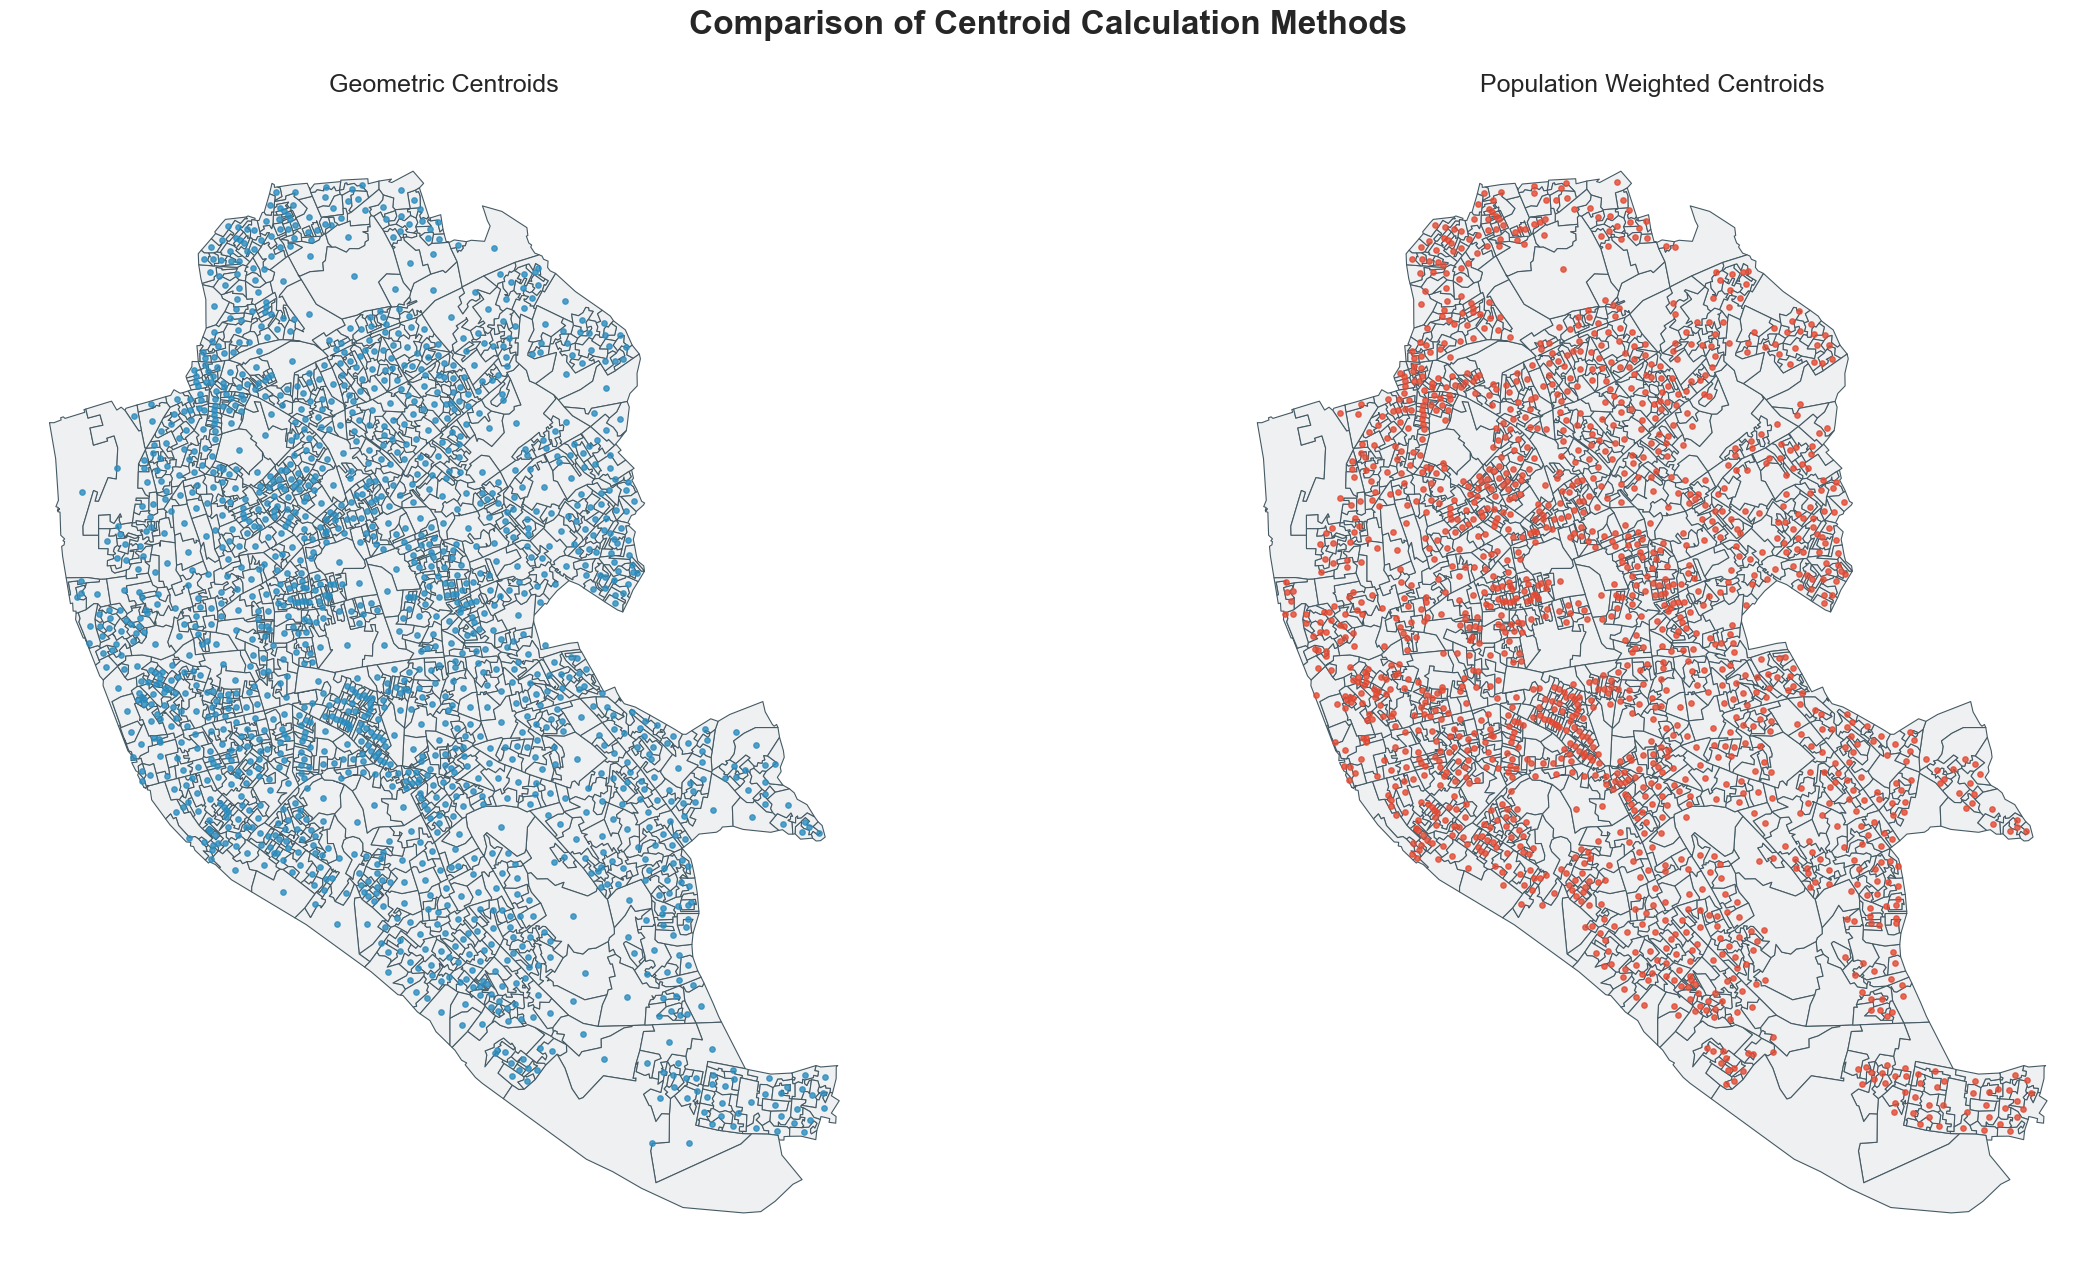

In [18]:
# Set a style for better aesthetics
plt.style.use('seaborn-v0_8-white')

fig, ax = plt.subplots(1, 2, figsize=(24, 12), constrained_layout=True)
fig.suptitle('Comparison of Centroid Calculation Methods', fontsize=24, fontweight='bold', y=1.05)

# Common plotting parameters
base_kwargs = {'color': '#eef0f2', 'edgecolor': '#455a64', 'linewidth': 0.8}
centroid_kwargs = {'markersize': 15, 'alpha': 0.8, 'zorder': 2}

# Subplot 1: Geometric Centroids
oa_with_features.plot(ax=ax[0], **base_kwargs)
oa_with_features.geometry.centroid.plot(
    ax=ax[0], 
    color='#2b8cbe', 
    label='Geometric Centroid', 
    **centroid_kwargs
)
ax[0].set_title('Geometric Centroids', fontsize=18, pad=20)
ax[0].axis('off')

# Subplot 2: Population Weighted Centroids
oa_with_features.plot(ax=ax[1], **base_kwargs)
if 'pop_weighted_centroid' in oa_with_features.columns:
    gpd.GeoSeries(oa_with_features['pop_weighted_centroid']).plot(
        ax=ax[1], 
        color='#e34a33', 
        label='Population Weighted Centroid', 
        **centroid_kwargs
    )

ax[1].set_title('Population Weighted Centroids', fontsize=18, pad=20)
ax[1].axis('off')

plt.show()

### 1.5 Calculate Network Centrality (Node Features)



In [19]:
# Construct homogeneous graph: Queen contiguity (OA polygons)
oa_graph_nx_calc = c2g.contiguity_graph(
    oa_with_features,
    contiguity="queen",
    node_geom_col="pop_weighted_centroid",
    set_point_nodes=True,
    as_nx=True
)

oa_graph_rx = c2g.nx_to_rx(oa_graph_nx_calc)

print("Calculating OA Betweenness...")
betweenness = rx.betweenness_centrality(oa_graph_rx)

print("Calculating OA Degree...")
degree = rx.degree_centrality(oa_graph_rx)

print("Calculating OA Closeness...")
closeness = rx.closeness_centrality(oa_graph_rx)

# Map results back to DataFrame
# We rely on the fact that nx_to_rx preserves node order from nx.nodes()
node_list = list(oa_graph_nx_calc.nodes())
oa_with_features['betweenness_centrality'] = [betweenness[i] for i in range(len(node_list))]
oa_with_features['degree_centrality'] = [degree[i] for i in range(len(node_list))]
oa_with_features['closeness_centrality'] = [closeness[i] for i in range(len(node_list))]

Calculating OA Betweenness...
Calculating OA Degree...
Calculating OA Closeness...


### 1.6 Save Data

In [20]:
# Process pop_weighted_centroid in OA_with_poi_counts before saving it
oa_with_features['pop_weighted_centroid'] = oa_with_features['pop_weighted_centroid'].to_wkt()

# Save to GeoPackage
oa_with_features.to_file(
    os.path.join(OUTPUT_DIR, "oa_with_features.gpkg"),
    driver="GPKG"
    )

## 2. Process features for Streets

### 2.1 Process Overture Maps Street Data

Download and clean the segment and connector layers that fall within the Liverpool Output Areas, then use `process_overture_segments` to build a usable street graph.

#### Download and process segments

As of Dec. 28th 2025, the latest release for Overture Maps API is "2025-12-17.0". However, under the current data retention policy, the data is only available for 60 days. While the policy was changed on September 24th, 2025, its direction could be subject to change ([discussion](https://github.com/orgs/OvertureMaps/discussions/422)).

If the parameter `release="2025-12-17.0"` does not work in `c2g.load_overture_data`, please try to use the latest release by not specifying the `release` parameter. To reproduce the result of this case study, please download the data from Zenodo.

In [21]:
# Prepare the OA extent in WGS84 for Overture Maps
liverpool_oa_wgs84 = liverpool_oa.to_crs(WGS84_CRS)
liverpool_bbox_wgs84 = list(liverpool_oa_wgs84.total_bounds)
liverpool_union = liverpool_oa.union_all()

# Download segments and connectors for that extent
street_data = c2g.load_overture_data(
    area=liverpool_bbox_wgs84,
    types=['segment', 'connector'],
    output_dir=OVERTURE_DIR,
    save_to_file=True,
    return_data=True,
    release="2025-12-17.0",
)

In [22]:
segments = street_data['segment']
connectors = street_data.get('connector')

segments = segments.to_crs(TARGET_CRS)
connectors = connectors.to_crs(TARGET_CRS) if not connectors.empty else connectors

In [23]:
processed_streets = c2g.process_overture_segments(
    segments,
    connectors_gdf=connectors,
    threshold=1.0,
    get_barriers=False    
)

processed_streets = processed_streets.to_crs(TARGET_CRS)

# Filter to only roads
processed_streets = processed_streets[processed_streets["subtype"] == "road"]

# Exclude non-pedestrian streets (motorway, bridleway, cycleway)
exclude_classes = ['motorway', 'bridleway', 'cycleway']
processed_streets = processed_streets[~processed_streets['class'].isin(exclude_classes)].copy()

In [24]:
# Clip and process the network
processed_streets = gpd.clip(processed_streets, liverpool_union)

# Calculate length
processed_streets['length'] = processed_streets.geometry.length

# Set travel time in seconds for pedestrians
processed_streets["travel_time_sec"] = processed_streets["length"] / (4.8 * 1000 / 3600)

# Convert to edges of graph
street_nodes, street_edges = c2g.segments_to_graph(processed_streets)

Removed 20 geometries with invalid types
Removed 13 invalid geometries


### 2.2 Calculate Centrality Measures for Streets

In [25]:
# Calculate Centrality Measures for Street Network
g_streets = c2g.gdf_to_nx(street_nodes, street_edges)

rx_streets = c2g.nx_to_rx(g_streets)

print("  - Betweenness")
betweenness = rx.betweenness_centrality(rx_streets)
print("  - Degree")
degree = rx.degree_centrality(rx_streets)
print("  - Closeness")
closeness = rx.closeness_centrality(rx_streets)

# Map to Street Nodes
node_list = list(g_streets.nodes())
street_nodes['betweenness_centrality'] = [betweenness[i] for i in range(len(node_list))]
street_nodes['degree_centrality'] = [degree[i] for i in range(len(node_list))]
street_nodes['closeness_centrality'] = [closeness[i] for i in range(len(node_list))]

  - Betweenness
  - Degree
  - Closeness


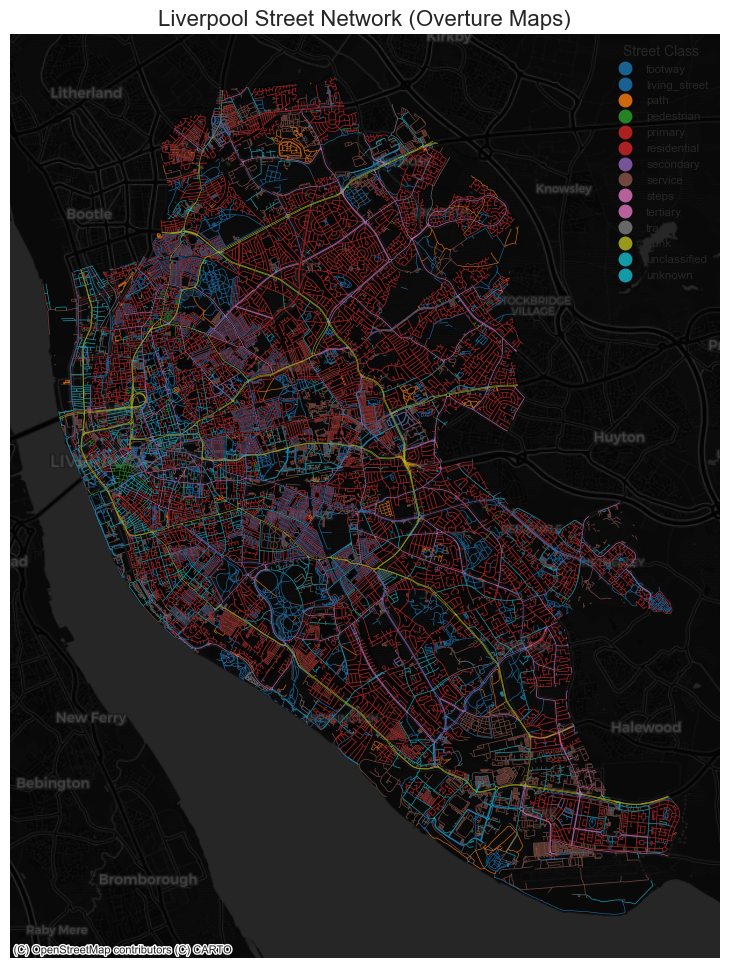

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot OA boundaries as a subtle background
liverpool_oa.to_crs("EPSG:3857").plot(ax=ax, color='none', edgecolor='black', linewidth=0.1, alpha=0.3)

# Plot the street network
street_edges.to_crs("EPSG:3857").plot(
    ax=ax, 
    column='class', 
    linewidth=0.5, 
    alpha=0.8,
    legend=True,
    legend_kwds={'loc': 'upper right', 'title': 'Street Class', 'fontsize': 'small'}
)

# Add a dark-themed basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter)

ax.set_title("Liverpool Street Network (Overture Maps)", fontsize=16)
ax.set_axis_off()
plt.show()

### 2.3 Save Data

In [27]:
# Save streets
STREET_NETWORK_PATH = os.path.join(OUTPUT_DIR, 'street_nodes.gpkg')
street_nodes.to_file(
    STREET_NETWORK_PATH,
    driver='GPKG',
)

STREET_NETWORK_PATH = os.path.join(OUTPUT_DIR, 'street_edges.gpkg')
street_edges.to_file(
    STREET_NETWORK_PATH,
    driver='GPKG',
)

## 3 Process GTFS for Public Transport Travel Summary

Load the North West GTFS feed and build a summary graph that aggregates travel time
and frequency between stops using `load_gtfs` and `travel_summary_graph`.

### 3.1 Load GTFS

In [28]:
# Build the travel summary graph from the GTFS feed
GTFS_PATH = "../data/raw/gtfs/itm_north_west_gtfs.zip"
gtfs_data = c2g.load_gtfs(GTFS_PATH)

In [29]:
print(list(gtfs_data.keys()))

['agency', 'stops', 'routes', 'calendar', 'calendar_dates', 'trips', 'shapes', 'feed_info', 'stop_times']


In [30]:
gtfs_data["feed_info"]

feed_publisher_name                feed_publisher_url feed_lang  \
0  Bus Open Data Service (BODS)  https://www.bus-data.dft.gov.uk/        EN   

  feed_start_date feed_end_date     feed_version  
0        20251210      21250928  20251210_045949

In [31]:
gtfs_data["calendar"]

service_id  monday  tuesday  wednesday  thursday  friday  saturday  \
0            2    True     True       True      True    True      True   
1            3   False    False      False     False   False      True   
2            5    True     True       True      True    True     False   
3           28    True     True       True      True    True     False   
4           29   False     True      False     False   False     False   
..         ...     ...      ...        ...       ...     ...       ...   
455      63398   False    False      False     False    True     False   
456      63434    True     True       True      True    True     False   
457      63517    True     True       True      True    True     False   
458      63966    True     True      False     False   False     False   
459      63967    True     True       True      True    True     False   

     sunday start_date  end_date  
0     False   20251210  20260910  
1     False   20251210  20260910  
2     False   20251210  20260910  
3     False   20251210  20260910  
4     False   20251210  20260910  
..      ...        ...       ...  
455   False   20251210  20260910  
456   False   20251210  20260910  
457   False   20251210  20260910  
458   False   20251210  20260910  
459   False   20251210  20260910  

[460 rows x 10 columns]

### 3.2 Construct Travel Summary Graph from GTFS

In [32]:
# Build travel summary graph for whole the duration between 20251210 and 20260910
travel_nodes, travel_edges = c2g.travel_summary_graph(gtfs_data)

# Reproject to TARGET_CRS
travel_nodes = travel_nodes.to_crs(TARGET_CRS)
travel_edges = travel_edges.to_crs(TARGET_CRS)

# Clip nodes to the Liverpool union
travel_nodes = gpd.clip(travel_nodes, liverpool_union)
travel_nodes = travel_nodes[~travel_nodes.geometry.is_empty & travel_nodes.geometry.notna()].copy()

# Clip edges to the Liverpool union, explode multi-part geometries, and drop any empty geometries
travel_edges = gpd.clip(travel_edges, liverpool_union)
travel_edges = travel_edges.explode(index_parts=False)
travel_edges = travel_edges[~travel_edges.geometry.is_empty & travel_edges.geometry.notna()].copy()

valid_stops = set(travel_nodes.index)
travel_edges = travel_edges[
    travel_edges.index.get_level_values('from_stop_id').isin(valid_stops) &
    travel_edges.index.get_level_values('to_stop_id').isin(valid_stops)
].copy()

/var/folders/_n/l2f9tkgn3g17dj7hnsjprssc0000gn/T/ipykernel_23664/3155216770.py:15: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  travel_edges = travel_edges[~travel_edges.geometry.is_empty & travel_edges.geometry.notna()].copy()


### 3.3 Calculate Centrality Measures for Travel Summary Graph

In [33]:
# Calculate Centrality Measures for Travel Summary Graph
g_travel = c2g.gdf_to_nx(travel_nodes, travel_edges)

rx_travel = c2g.nx_to_rx(g_travel)

print("  - Betweenness")
betweenness = rx.betweenness_centrality(rx_travel)
print("  - Degree")
degree = rx.degree_centrality(rx_travel)
print("  - Closeness")
closeness = rx.closeness_centrality(rx_travel)

# Map to Nodes
node_list = list(g_travel.nodes())
travel_nodes['betweenness_centrality'] = [betweenness[i] for i in range(len(node_list))]
travel_nodes['degree_centrality'] = [degree[i] for i in range(len(node_list))]
travel_nodes['closeness_centrality'] = [closeness[i] for i in range(len(node_list))]


  - Betweenness
  - Degree
  - Closeness


<Axes: >

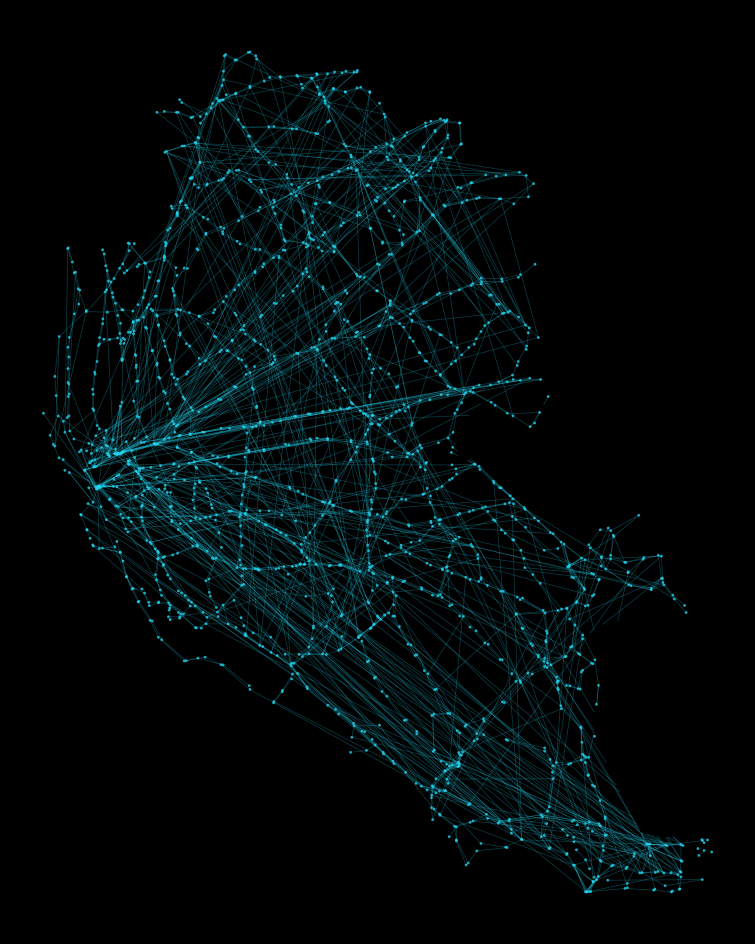

In [34]:
c2g.plot_graph(nodes=travel_nodes, edges=travel_edges)

### 3.3 Save Data

In [35]:
TRAVEL_NODE_PATH = os.path.join(OUTPUT_DIR, 'travel_summary_nodes.gpkg')
travel_nodes.to_file(TRAVEL_NODE_PATH, driver='GPKG')

TRAVEL_EDGE_PATH = os.path.join(OUTPUT_DIR, 'travel_summary_edges.gpkg')
travel_edges.to_file(TRAVEL_EDGE_PATH, driver='GPKG')